<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M3_LSTM_Exercise_Seession_2_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Starbucks Stock Data

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/SBUX.jpeg" width="700">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/aaubs/ds-master/main/data/M4-LSTM-SBUX.csv', index_col = 'Date', parse_dates=True)

In [2]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,81.523048,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,83.048248,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,83.481339,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,83.584900,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,82.972931,7296900


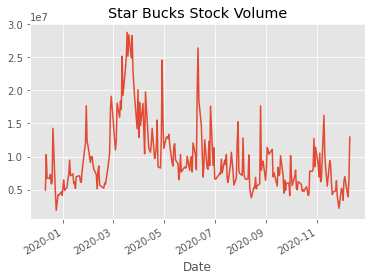

In [3]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Star Bucks Stock Volume')

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6] 

In [5]:
y

,Volume
Date,
2019-12-11,4921900
2019-12-12,10282100
2019-12-13,6714100
2019-12-16,6705600
2019-12-17,7296900
...,...
2020-12-04,6952700
2020-12-07,4514800
2020-12-08,3911300


In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [7]:
#first 200 for training

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :] 

In [8]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [9]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [10]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [11]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 16
output_size = 1
num_epochs= 10

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

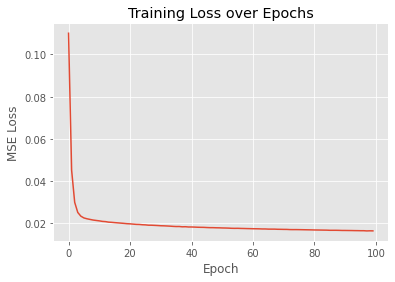

In [13]:
# Initializing Hyperparameters
num_epochs = 100
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [14]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.009174274790061112


In [15]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

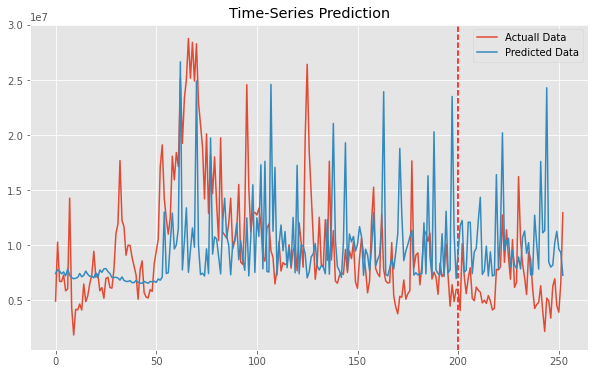

In [16]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y.Volume.values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [17]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

<All keys matched successfully>